In [1]:
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

plt.rcParams.update({'font.size': 12})

sys.path.insert(0, '..')
from simantha import Source, Machine, Buffer, Sink, Repairman, System, simulation
from simantha.utils import *

### Simulator validation

- System implemented in Simio and Simantha
- Run for 100 replications
- Compare system production (in units) and machine availability
- Distribution of samples compared using two-sample KS test

Scenarios examined:

- Single machine with no degradation
- Single machine with degradation and corrective maintenance
- 2M1B with no degradation
- 2M1B with degradtion

In [2]:
def plot_histograms(simantha_data, simio_data, statistic=''):
    plt.figure(figsize=(12,6))

    lower = min(min(simantha_data), min(simio_data))
    upper = max(max(simantha_data), max(simio_data))

    #bins = np.arange(lower, upper, 1)
    bins = np.linspace(lower, upper, len(simantha_data))

    step_hist_args = {
        'alpha': 0.8, 
        'histtype': 'step', 
        'normed': True, 
        'cumulative': True, 
        'lw': 2,
        'bins': bins
    }

    plt.hist(
        simantha_data,
        label=f'Simantha, mean={np.mean(simantha_data):.4f}', 
        **step_hist_args
    )
    plt.hist(
        simio_data,
        label=f'Simio, mean={np.mean(simio_data):.4f}', 
        **step_hist_args
    )

    _, p_value = scipy.stats.ks_2samp(simantha_data, simio_data)

    plt.title(f'{statistic}\nn={len(simantha_data)}, two-sample KS test p-value: {p_value:.4f}')
    plt.xlabel('Value')
    plt.ylabel('Frequency (cumulative)')

    plt.legend(loc='upper left')

    plt.show()

### Single-machine

- Cycle time: 1 minute
- Run time: 1 day (1440 minutes)
- Degradation: None
- Maintenance: None

In [3]:
source = Source()
M1 = Machine('M1', cycle_time=1)
sink = Sink()

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(upstream=[sink])

system = System(objects=[source, M1, sink])

system.simulate(simulation_time=1440)

Simulation finished in 0.05s
Parts produced: 1440


### Single machine with degradation

- Cycle time: 1 minute
- Run time: 1 day (1440 minutes)
- Degradation: $p=0.1$, $h_\max=10$, Negative binomial: $NB(r=10, p=0.1)+10$
- Maintenance: corrective, $TTR \sim U(5,10)$

Simio settings
- Source interarrival time: 1 minute
- Machine processing time: 1 minute
- Uptime between failures: `Random.NegativeBinomial(0.1, 10) + 10` minutes
- Time to repair: `Random.Discrete(20, 1/11, 21, 2/11, 22, 3/11, 23, 4/11, 24, 5/11, 25, 6/11, 26, 7/11, 27, 8/11, 28, 9/11, 29, 10/11, 30, 1)` minutes

Experiment responses
- Availability: `(100 - Server1.ResourceState.PercentTime(3)) / 100`
- Production: `M1.Processing.NumberExited`

In [4]:
T = WEEK
p = 0.15
h_max = 100

degradation_matrix = generate_degradation_matrix(p=p, h_max=h_max)

a, b = [20, 30]
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=degradation_matrix,
    cm_distribution=cm_distribution
)
sink = Sink()

objects = [source, M1, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[sink])
sink.define_routing(downstream=[sink])

system = System(objects=objects)

In [26]:
system.simulate(simulation_time=100, debug=False)

Simulation finished in 0.01s
Parts produced: 100


In [5]:
simantha_results = system.iterate_simulation(replications=1000, simulation_time=T, jobs=10, verbose=True)

Finished 1000 replications in 55.88s


In [7]:
simantha_production = [s[0] for s in simantha_results]
simantha_availability = [s[2][0] for s in simantha_results]

simio_results = pd.read_csv('single_machine_line_Model_Experiment1_ResponseDetail_rare_failures.csv')

simio_production = simio_results['M1_production']
simio_availability = simio_results['M1_availability']

In [8]:
print('Summary:')
print('  Simantha')
print(f'    Average production:   {np.mean(simantha_production):.4f}')
print(f'    Average availability: {np.mean(simantha_availability):.4f}')
print('  Simio')
print(f'    Average production:   {np.mean(simio_production):.4f}')
print(f'    Average availability: {np.mean(simio_availability):.4f}')

Summary:
  Simantha
    Average production:   9728.0560
    Average availability: 0.9651
  Simio
    Average production:   9722.6940
    Average availability: 0.9651


1.0293696275071633

In [90]:
# run with 26, then 27
# state carries over, specifically M1.can_receive() returns False at start of 27
random.seed(26)
system.simulate(simulation_time=utils.WEEK, trace=True)

Simulation finished in 0.52s
Parts produced: 9708


In [91]:
M1.can_receive()

False

In [6]:
1.3268 / 60

0.022113333333333332

In [8]:
60 * 0.128283

7.696980000000001

In [89]:
trace = pd.DataFrame(pd.read_pickle('trace.pkl'))[['time', 'location', 'action', 'status', 'group', 'order', 'priority']]
trace.to_csv('C:/Users/Michael/Downloads/trace.csv')

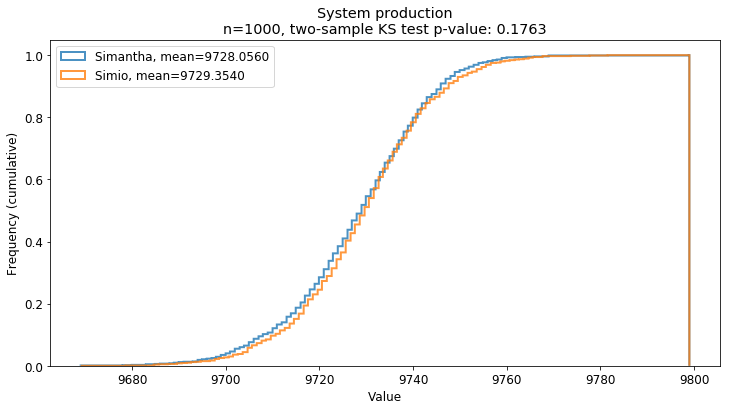

In [26]:
plot_histograms(simantha_production, simio_production+6.66002, 'System production')

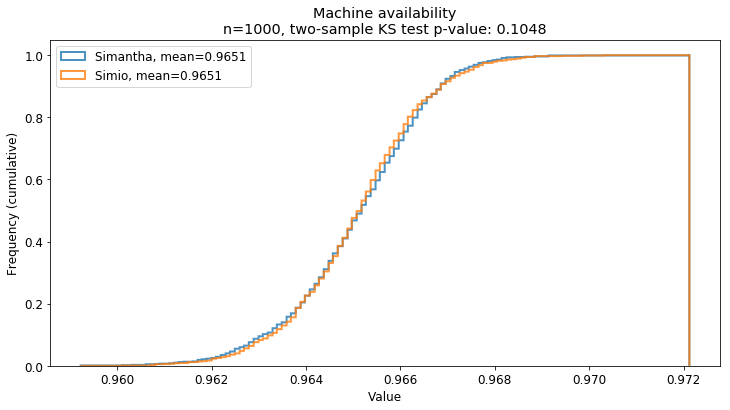

In [17]:
plot_histograms(simantha_availability, simio_availability, 'Machine availability')

### 2M1B line with degradation

- Machine 1
  - Cycle time: 1 minute
  - Degradation: $p=0.15$, $h_\max=20$
- Machine 2
  - Cycle time: 1 minute
  - Degradation: $p=0.1$, $h_\max=20$
- B1 capacity: 10
- Maintenance: corrective, $TTR \sim U(20, 30)$
- Run time: 1 day

Simio settings
- Source interarrival time: 1 minute
- Machine 1
  - Processing time: 1 minute
  - Uptime between failures: `Random.NegativeBinomial(0.15, 20) + 20` minutes
  - Time to repair: `Random.Discrete(20, 1/11, 21, 2/11, 22, 3/11, 23, 4/11, 24, 5/11, 25, 6/11, 26, 7/11, 27, 8/11, 28, 9/11, 29, 10/11, 30, 1)` minutes
- Machine 2
  - Processing time: 1 minute
  - Input buffer capacity: 20
  - Uptime between failures: `Random.NegativeBinomial(0.15, 20) + 20` minutes
  - Time to repair: `Random.Discrete(20, 1/11, 21, 2/11, 22, 3/11, 23, 4/11, 24, 5/11, 25, 6/11, 26, 7/11, 27, 8/11, 28, 9/11, 29, 10/11, 30, 1)` minutes

In [27]:
T = 1 * 24 * 60
p_1 = 0.15
p_2 = 0.1
h_max_1 = h_max_2 = 20

Q_1 = generate_degradation_matrix(p=p_1, h_max=h_max_1)
Q_2 = generate_degradation_matrix(p=p_2, h_max=h_max_2)

a, b = [20, 30]
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=Q_1,
    cm_distribution=cm_distribution
)
B1 = Buffer(capacity=1)
M2 = Machine(
    name='M2', 
    cycle_time=1,
    degradation_matrix=Q_2,
    cm_distribution=cm_distribution
)
sink = Sink()

objects = [source, M1, B1, M2, sink]

source.define_routing(downstream=[M1])
M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2])
M2.define_routing(upstream=[B1], downstream=[sink])
sink.define_routing(upstream=[M2])

repairman = Repairman(capacity=1)

system = System(objects=objects, repairman=repairman)

#system.simulate(simulation_time=30*24*60)

In [28]:
simantha_results = system.iterate_simulation(1000, simulation_time=1000, jobs=10)

Finished 1000 replications in 8.67s


In [10]:
# expected downtime
mttf_1 = h_max_1 / p_1
mttf_2 = h_max_2 / p_2

mttr_1 = mttr_2 = (a + b) / 2

A_1 = mttf_1 / (mttf_1 + mttr_1)
A_2 = mttf_2 / (mttf_2 + mttr_2)

print(f'Expected downtime')
print(f'  M1: {1-A_1:.4%}')
print(f'  M2: {1-A_2:.4%}')

# expected production
print(f'Expected production:')
print(f'  M1: {A_1*7*24*60:.4f} units')
print(f'  M2: {A_2*7*24*60:.4f} units')

Expected downtime
  M1: 15.7895%
  M2: 11.1111%
Expected production:
  M1: 8488.4211 units
  M2: 8960.0000 units


In [29]:
simantha_production = [s[0] for s in simantha_results]
simantha_m1_prod = [s[1][0] for s in simantha_results]
simantha_m2_prod = [s[1][1] for s in simantha_results]
simantha_m1_avail = [s[2][0] for s in simantha_results]
simantha_m2_avail = [s[2][1] for s in simantha_results]

simio_results = pd.read_csv('2m1b_line_Model_Experiment1_ResponseDetail_1000_1week_1.csv')

simio_production = simio_results['Production']
simio_m1_prod = simio_results['M1_production']
simio_m2_prod = simio_results['M2_production']
simio_m1_avail = simio_results['M1_availability']
simio_m2_avail = simio_results['M2_availability']

print('Summary')
print('  Simantha')
print(f'    Average production: {np.mean(simantha_production):.4f}')
print(f'    M1 production:      {np.mean(simantha_m1_prod):.4f}')
print(f'    M1 availability:    {np.mean(simantha_m1_avail):.4f}')
print(f'    M2 production:      {np.mean(simantha_m2_prod):.4f}')
print(f'    M2 availability:    {np.mean(simantha_m2_avail):.4f}')
print('  Simio')
print(f'    Average production: {np.mean(simio_production):.4f}')
print(f'    M1 production:      {np.mean(simio_m1_prod):.4f}')
print(f'    M1 availability:    {np.mean(simio_m1_avail):.4f}')
print(f'    M2 production:      {np.mean(simio_m2_prod):.4f}')
print(f'    M2 availability:    {np.mean(simio_m2_avail):.4f}')

Summary
  Simantha
    Average production: 754.1240
    M1 production:      754.9740
    M1 availability:    0.8458
    M2 production:      754.1240
    M2 availability:    0.8926
  Simio
    Average production: 7800.2210
    M1 production:      7841.1370
    M1 availability:    0.8355
    M2 production:      7800.2210
    M2 availability:    0.8823


7430.589432

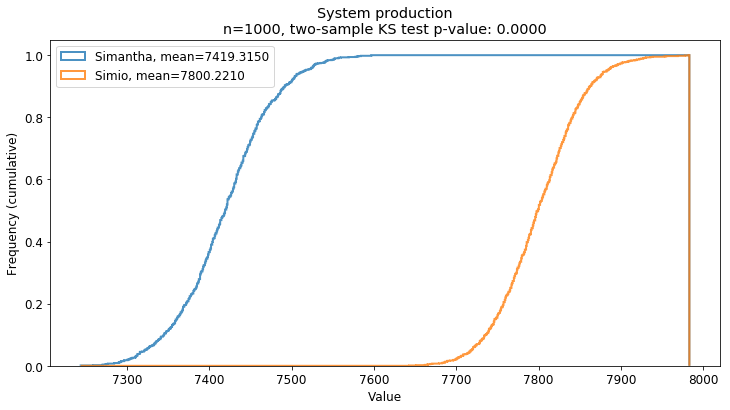

In [18]:
plot_histograms(simantha_production, simio_production, 'System production')

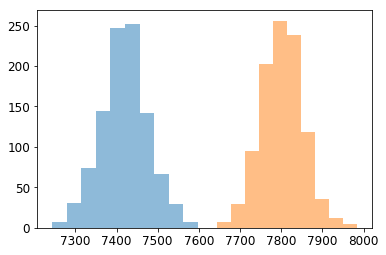

In [26]:
plt.hist(simantha_production, alpha=0.5)
plt.hist(simio_production, alpha=0.5)
plt.show()

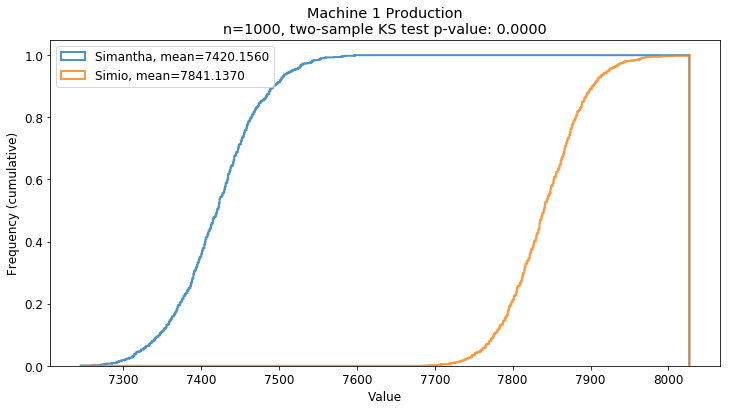

In [19]:
plot_histograms(simantha_m1_prod, simio_m1_prod, 'Machine 1 Production')

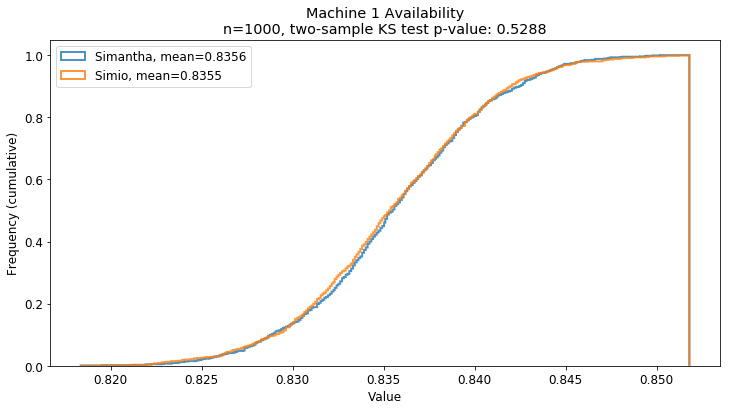

In [20]:
plot_histograms(simantha_m1_avail, simio_m1_avail, 'Machine 1 Availability')

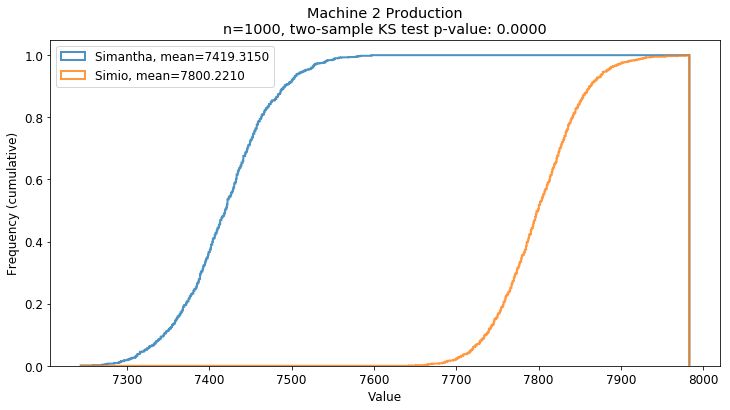

In [21]:
plot_histograms(simantha_m2_prod, simio_m2_prod, 'Machine 2 Production')

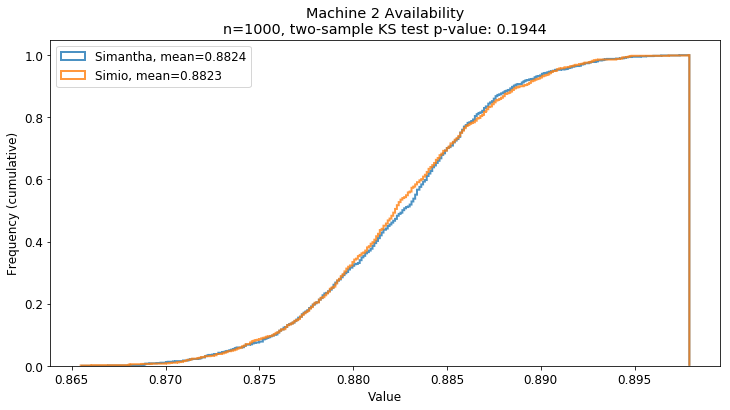

In [11]:
plot_histograms(simantha_m2_avail, simio_m2_avail, 'Machine 2 Availability')

### Three machines in parallel

In [88]:
T = 1 * 24 * 60
p = 0.1
h_max = 10

Q = utils.generate_degradation_matrix(p=p, h_max=h_max)

a, b = [5, 10]
cm_distribution = {'uniform': [a, b]}

source = Source()
M1 = Machine(
    name='M1', 
    cycle_time=1,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
B1 = Buffer(capacity=10)
M2 = Machine(
    name='M2', 
    cycle_time=3,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
M3 = Machine(
    name='M3', 
    cycle_time=3,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
M4 = Machine(
    name='M4', 
    cycle_time=3,
    degradation_matrix=Q,
    cm_distribution=cm_distribution
)
sink = Sink()

objects = [source, M1, B1, M2, M3, M4, sink]

M1.define_routing(upstream=[source], downstream=[B1])
B1.define_routing(upstream=[M1], downstream=[M2, M3, M4])
for machine in [M2, M3, M4]:
    machine.define_routing(upstream=[B1], downstream=[sink])

repairman = Repairman(capacity=1)
    
system = System(objects=objects, repairman=repairman)

In [89]:
simantha_results = system.iterate_simulation(500, simulation_time=1*24*60, jobs=10)

Finished 500 replications in 7.73s


In [90]:
simantha_production = [s[0] for s in simantha_results]
simantha_m1_prod = [s[1][0] for s in simantha_results]
simantha_m2_prod = [s[1][1] for s in simantha_results]
simantha_m3_prod = [s[1][2] for s in simantha_results]
simantha_m4_prod = [s[1][3] for s in simantha_results]
simantha_m1_avail = [s[2][0] for s in simantha_results]
simantha_m2_avail = [s[2][1] for s in simantha_results]
simantha_m3_avail = [s[2][2] for s in simantha_results]
simantha_m4_avail = [s[2][3] for s in simantha_results]

simio_results = pd.read_csv('parallel_station_line_Model_Experiment1_ResponseDetail_500.csv')

simio_production = simio_results['SystemProduction']
simio_m1_prod = simio_results['M1_production']
simio_m2_prod = simio_results['M2_production']
simio_m3_prod = simio_results['M3_production']
simio_m4_prod = simio_results['M4_production']
simio_m1_avail = simio_results['M1_availability']
simio_m2_avail = simio_results['M2_availability']
simio_m3_avail = simio_results['M3_availability']
simio_m4_avail = simio_results['M4_availability']

In [55]:
1164.54 + (12.9 * 4)

1216.1399999999999

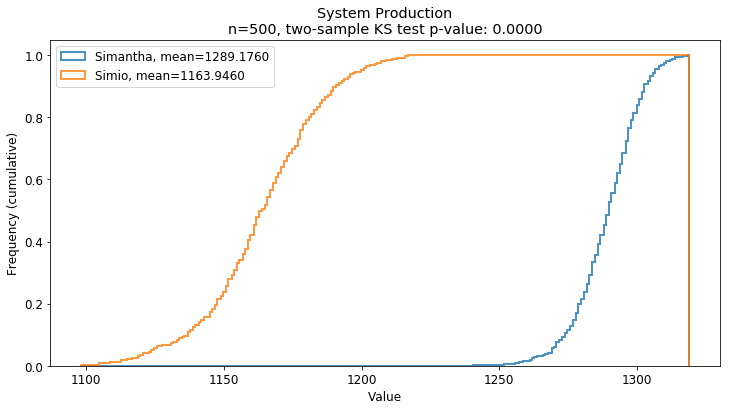

In [91]:
plot_histograms(simantha_production, simio_production, 'System Production')

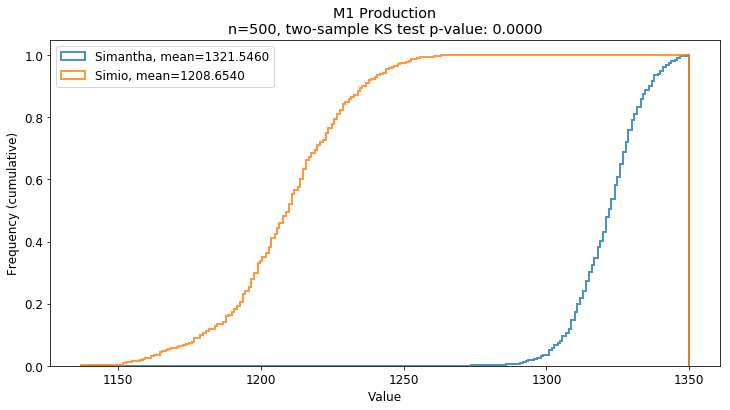

In [92]:
plot_histograms(simantha_m1_prod, simio_m1_prod, 'M1 Production')

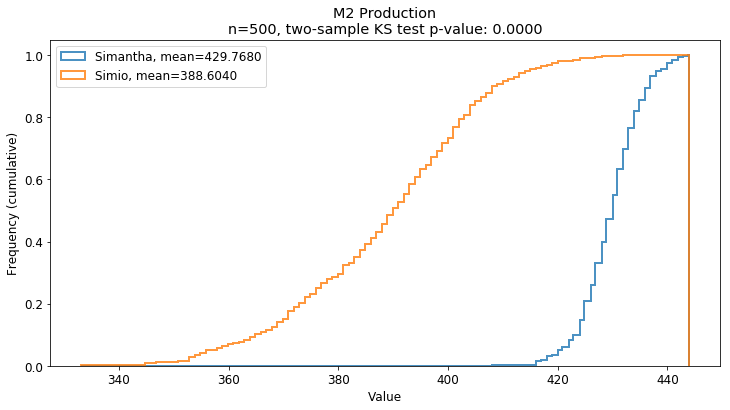

In [93]:
plot_histograms(simantha_m2_prod, simio_m2_prod, 'M2 Production')

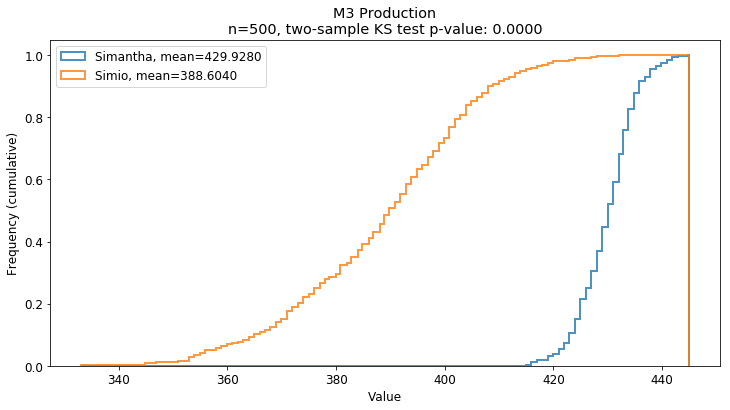

In [94]:
plot_histograms(simantha_m3_prod, simio_m3_prod, 'M3 Production')

In [97]:
print(np.mean(simio_m2_prod))
print(np.mean(simio_m3_prod))
print(np.mean(simio_m4_prod))
print()
print(np.mean(simantha_m2_prod))
print(np.mean(simantha_m3_prod))
print(np.mean(simantha_m4_prod))

388.604
388.604
388.682

429.768
429.928
429.48


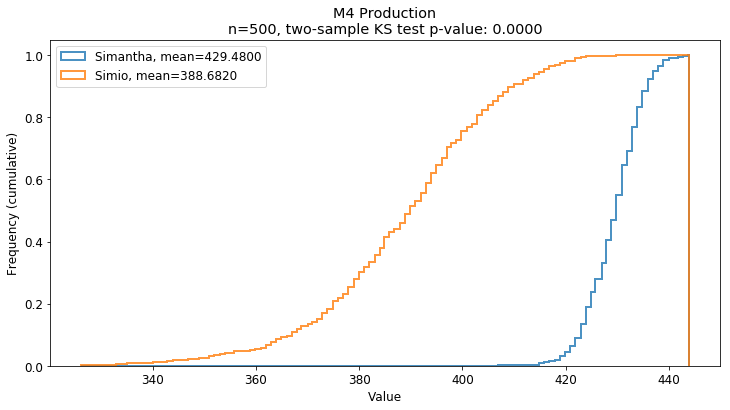

In [96]:
plot_histograms(simantha_m4_prod, simio_m4_prod, 'M4 Production')

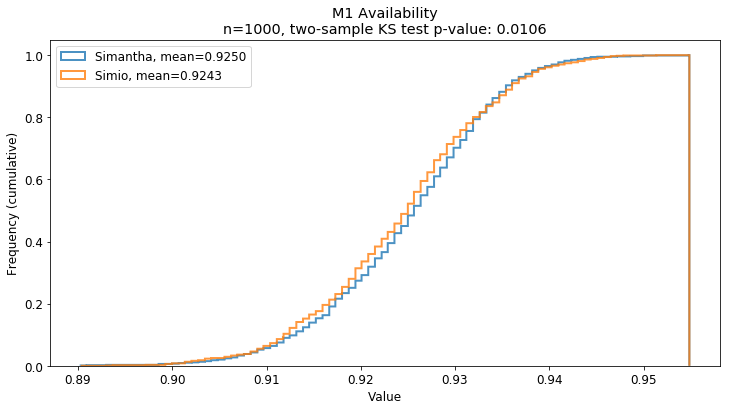

In [66]:
plot_histograms(simantha_m1_avail, simio_m1_avail, 'M1 Availability')

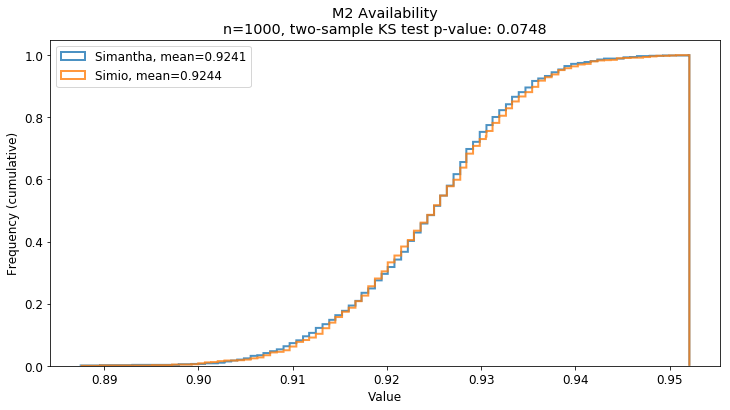

In [67]:
plot_histograms(simantha_m2_avail, simio_m2_avail, 'M2 Availability')

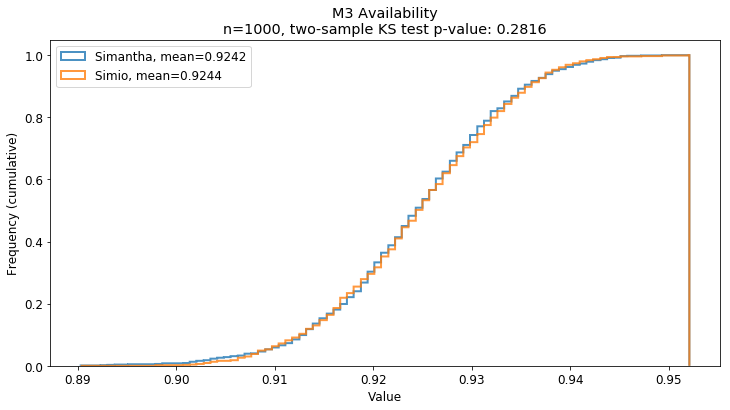

In [68]:
plot_histograms(simantha_m3_avail, simio_m3_avail, 'M3 Availability')

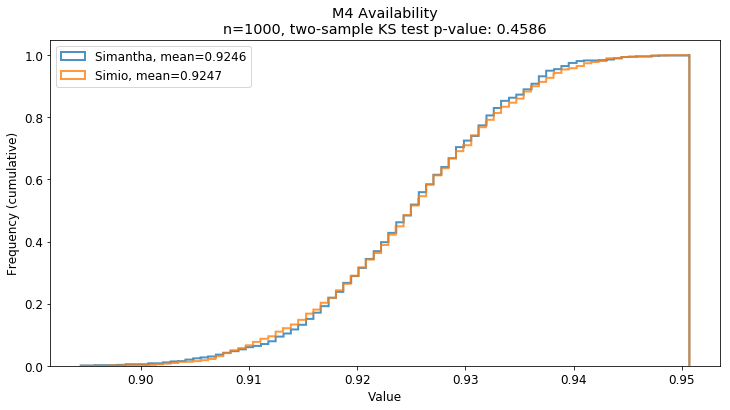

In [35]:
plot_histograms(simantha_m4_avail, simio_m4_avail, 'M4 Availability')